***Import library***

In [28]:
# Import basic library to processing data
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [29]:
# Import statics model using for running model 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [30]:
df = pd.read_csv(r"https://raw.githubusercontent.com/BrianNguyen2001/Government-Bond-Yield-Forcasting/main/Bond-VN.csv", index_col= 0)
df = pd.DataFrame(df['GGVF5Y'])


In [31]:
nobs = int(len(df)*0.2)
df_train, df_test = df[0:-nobs], df[-nobs:]

In [32]:
# n_state = 501
# x_train, x_test = train_test_split(x, train_size = 0.7, test_size = 0.3, random_state=n_state) 

In [33]:
x = df.GGVF5Y

***Data Processing***

In [34]:
# Create a first difference column.
# df_train = pd.DataFrame(x_train.sort_index())
df_train['1st_diff'] = df_train.diff()
df_train = df_train.dropna()

<ipython-input-34-8d1b9329b4aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['1st_diff'] = df_train.diff()


In [35]:
df_train

,GGVF5Y,1st_diff
Time,,
2006-08,0.08325,-0.00345
2006-09,0.08393,0.00068
2006-10,0.08388,-0.00005
2006-11,0.08417,0.00029
2006-12,0.08292,-0.00125
...,...,...
2016-12,0.05600,0.00187
2017-01,0.05290,-0.00310
2017-02,0.05055,-0.00235


***ADF test and KPSS test***

In [36]:
# Function ADF test
def adf_test(x):

    stats_index = ['Test Statistic', 'p-value', '# of Lags Used', '# of Observations Used']

    test_adf = adfuller(x, autolag='AIC')
    results = pd.Series(test_adf[0:4], index = stats_index)

    for key, value in test_adf[4].items():
        results[f'Critical Value ({key})'] = value

    return results

In [37]:
# Test ADF with the adjust close price.
print('ADF test result of the GVB5Y:')
adf_test(df_train['1st_diff'])

ADF test result of the GVB5Y:


Test Statistic           -6.042206e+00
p-value                   1.337651e-07
# of Lags Used            4.000000e+00
# of Observations Used    1.240000e+02
Critical Value (1%)      -3.484220e+00
Critical Value (5%)      -2.885145e+00
Critical Value (10%)     -2.579359e+00
dtype: float64

In [38]:
# Function KPSS test
def kpss_test(x):

    stats_index = ['Test Statistic', 'p-value', '# of Lags']

    test_kpss = kpss(x)
    results = pd.Series(test_kpss[0:3], index = stats_index)

    for key, value in test_kpss[3].items():
        results[f'Critical Value ({key})'] = value

    return results

In [39]:
# Test KPSS with the adjust close price.
print('KPSS test result of the GVB5Y:')
kpss_test(df_train['1st_diff'])

KPSS test result of the GVB5Y:


c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Test Statistic           0.061335
p-value                  0.100000
# of Lags                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

*Test with the first difference*

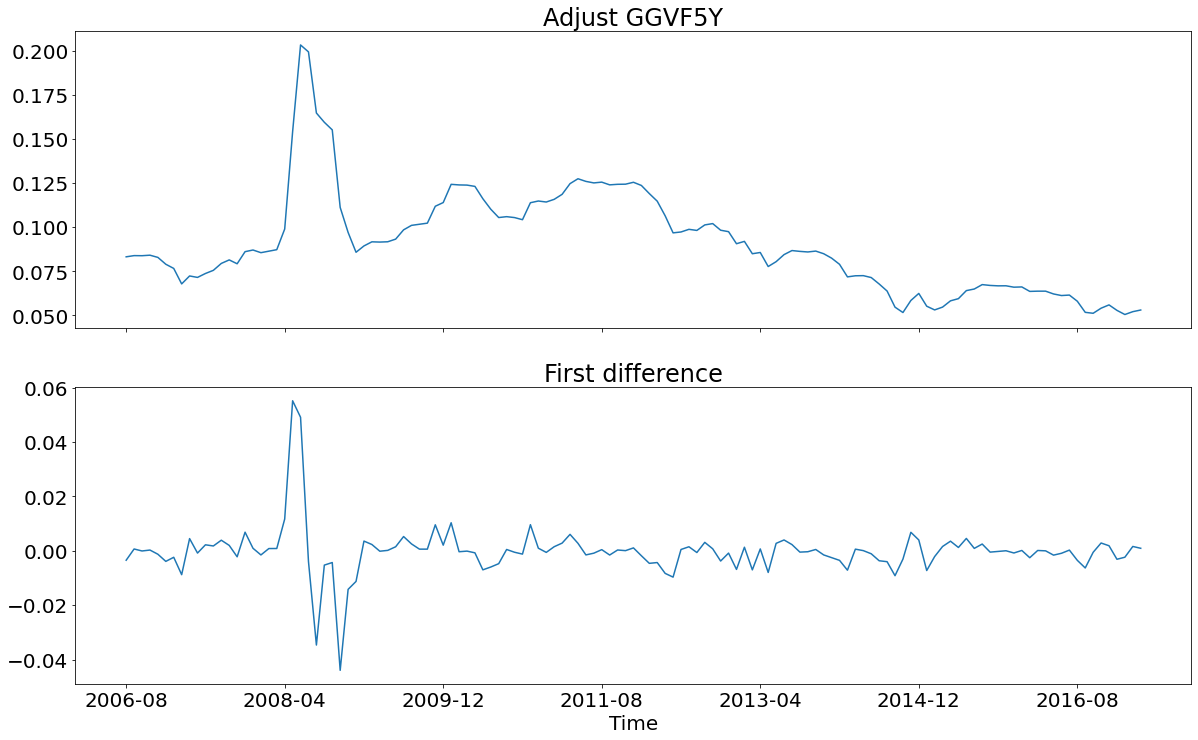

In [40]:
# Update size and font for image
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'font.size': 20})

# Ploting two adjust close price and first difference chart
fig, ax = plt.subplots(2, sharex = True)
df_train['GGVF5Y'].plot(ax = ax[0], title = 'Adjust GGVF5Y')
df_train['1st_diff'].plot(ax = ax[1], title = 'First difference')

plt.show()

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


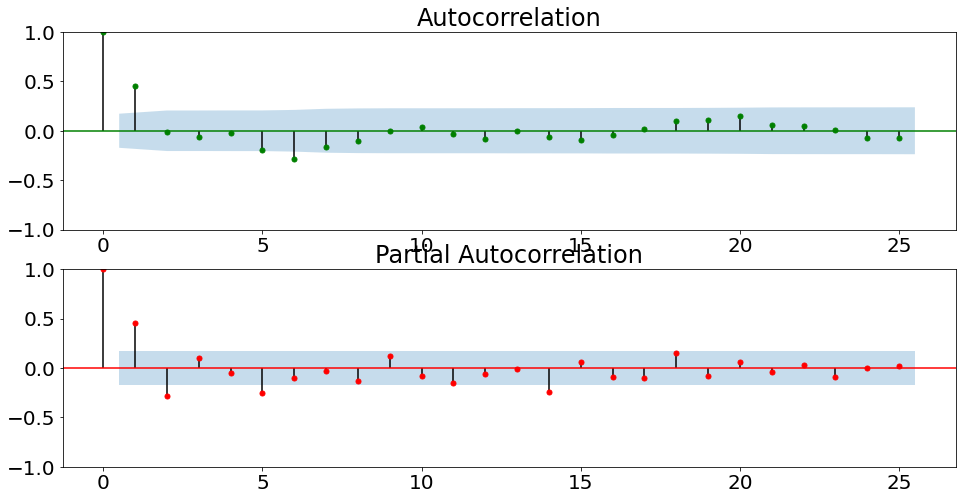

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Specify parameters
n_lags = 25
significance_level = 0.05

# Update size and font for image
%matplotlib inline
plt.rcParams['figure.figsize'] = [22, 18]
plt.rcParams.update({'font.size': 20}) 

# Draw plot
fig, ax = plt.subplots(2, figsize=(16, 8))

# Plot ACF
plot_acf(df_train['1st_diff'], ax = ax[0], lags = n_lags, 
         alpha = significance_level, c= 'green')

# Plot PACF
plot_pacf(df_train['1st_diff'], ax = ax[1], lags = n_lags, 
          alpha = significance_level,c= 'red')

plt.show()

In [42]:
import pmdarima as pm

In [43]:
# Using auto-arima to seek the the “p, d, q” parameters.
arima = pm.auto_arima(df_train.GGVF5Y, start_p=0, start_q=0,
                                    max_p=5, max_q=5, m=12,
                                    start_P=0, seasonal=True,
                                    d=1, D=1, trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-658.390, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-722.272, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-681.192, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-739.668, Time=1.77 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-744.773, Time=2.77 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-745.497, Time=1.28 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=-743.371, Time=1.74 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=1.57 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=-739.676, Time=1.44 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-721.614, Time=0.64 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=-752.341, Time=1.05 sec
 ARIMA(2,1,0)(0,1,1)[12]             : 

***ARMIA model results***

In [44]:
print(arima.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  129
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 381.170
Date:                              Wed, 27 Jul 2022   AIC                           -752.341
Time:                                      23:17:48   BIC                           -738.573
Sample:                                           0   HQIC                          -746.752
                                              - 129                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5634      0.083      6.766      0.000       0.400       0.727
ar.L2         -0.27

***White residual test***

In [45]:
def arima_diagnostics(resids, n_lags=25):
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    # Calculate resids
    r = resids
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # residuals over time
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
    ax1.set_title('Standardized residuals')

    # Distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    # Plot distribution
    sns.distplot(resids_nonmissing, hist=True, kde=True, 
                 norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
        
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')

    # ACF plot
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF plot')

    return fig

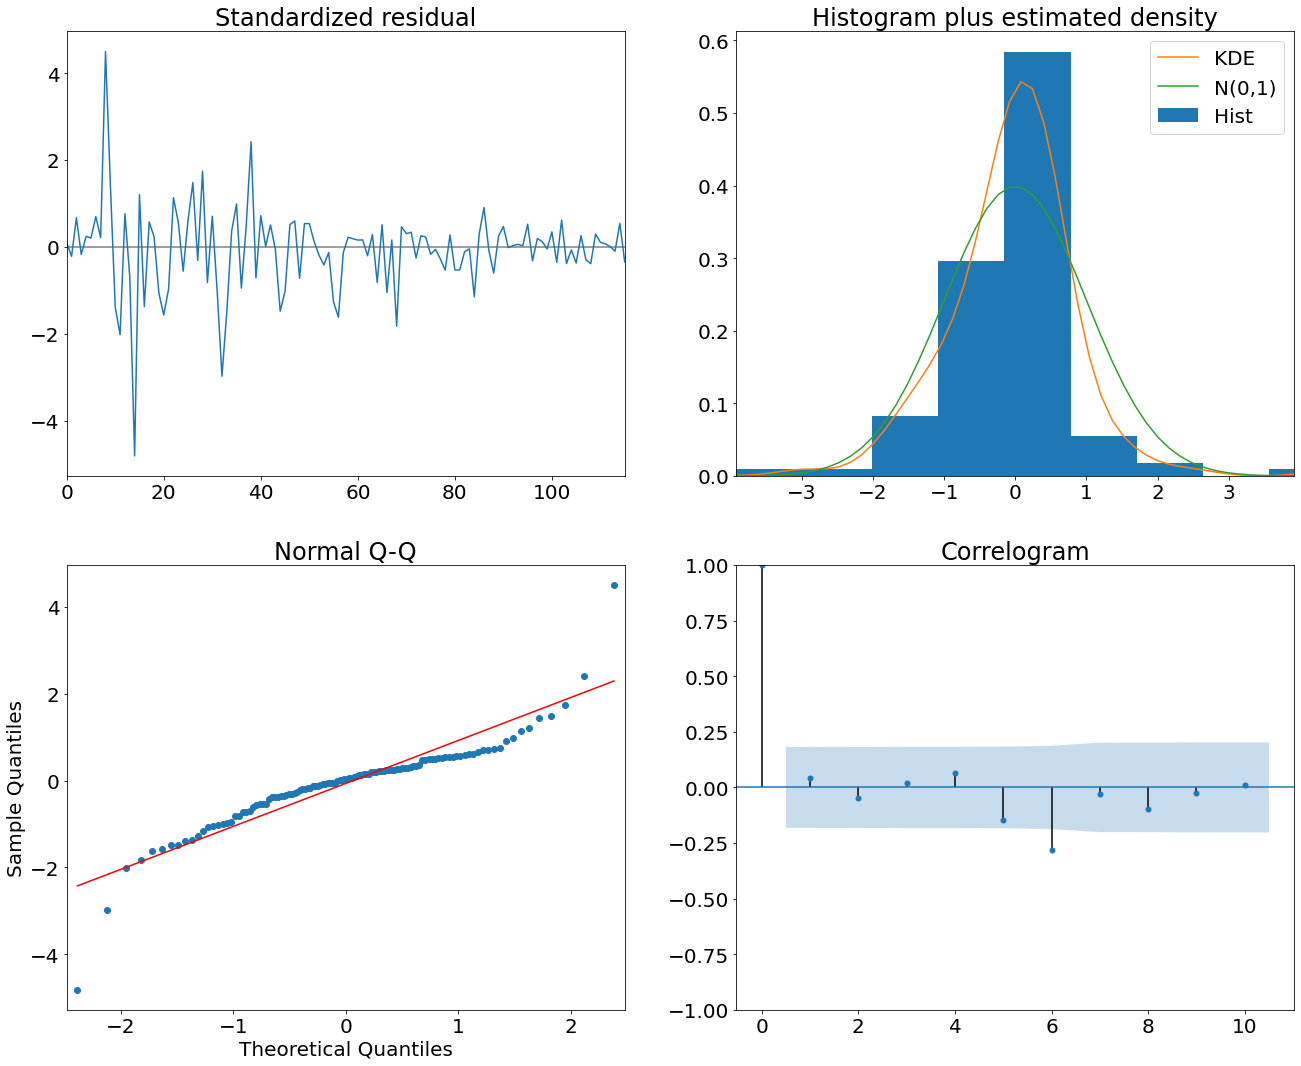

In [46]:
# Run residual testing function
arima.plot_diagnostics()
plt.show();

***Forcast future value***

In [47]:
# import data used for forcasting
# data_forecast = pd.DataFrame(x_test.sort_index())
data_forecast = df_test

In [48]:
# Forecast length
n_forecasts = len(data_forecast)

# ARIMA forecast restults
arima_forcast = arima.predict(n_forecasts)

# Concatenate forecast data
arima_forcast = pd.DataFrame(arima_forcast,index=data_forecast.index, columns=['Predict'])


In [49]:
volatility = pd.DataFrame({'Real': data_forecast.GGVF5Y,
                           'Prediction': arima_forcast.Predict},
                           index= data_forecast.index)

In [50]:
volatility.to_excel('ARIMA_5y.xlsx')

In [51]:
volatility.head()

,Real,Prediction
Time,,
2017-05,0.05078,0.052369
2017-06,0.04940,0.055149
2017-07,0.04712,0.055212
2017-08,0.04986,0.054096
2017-09,0.04708,0.052266


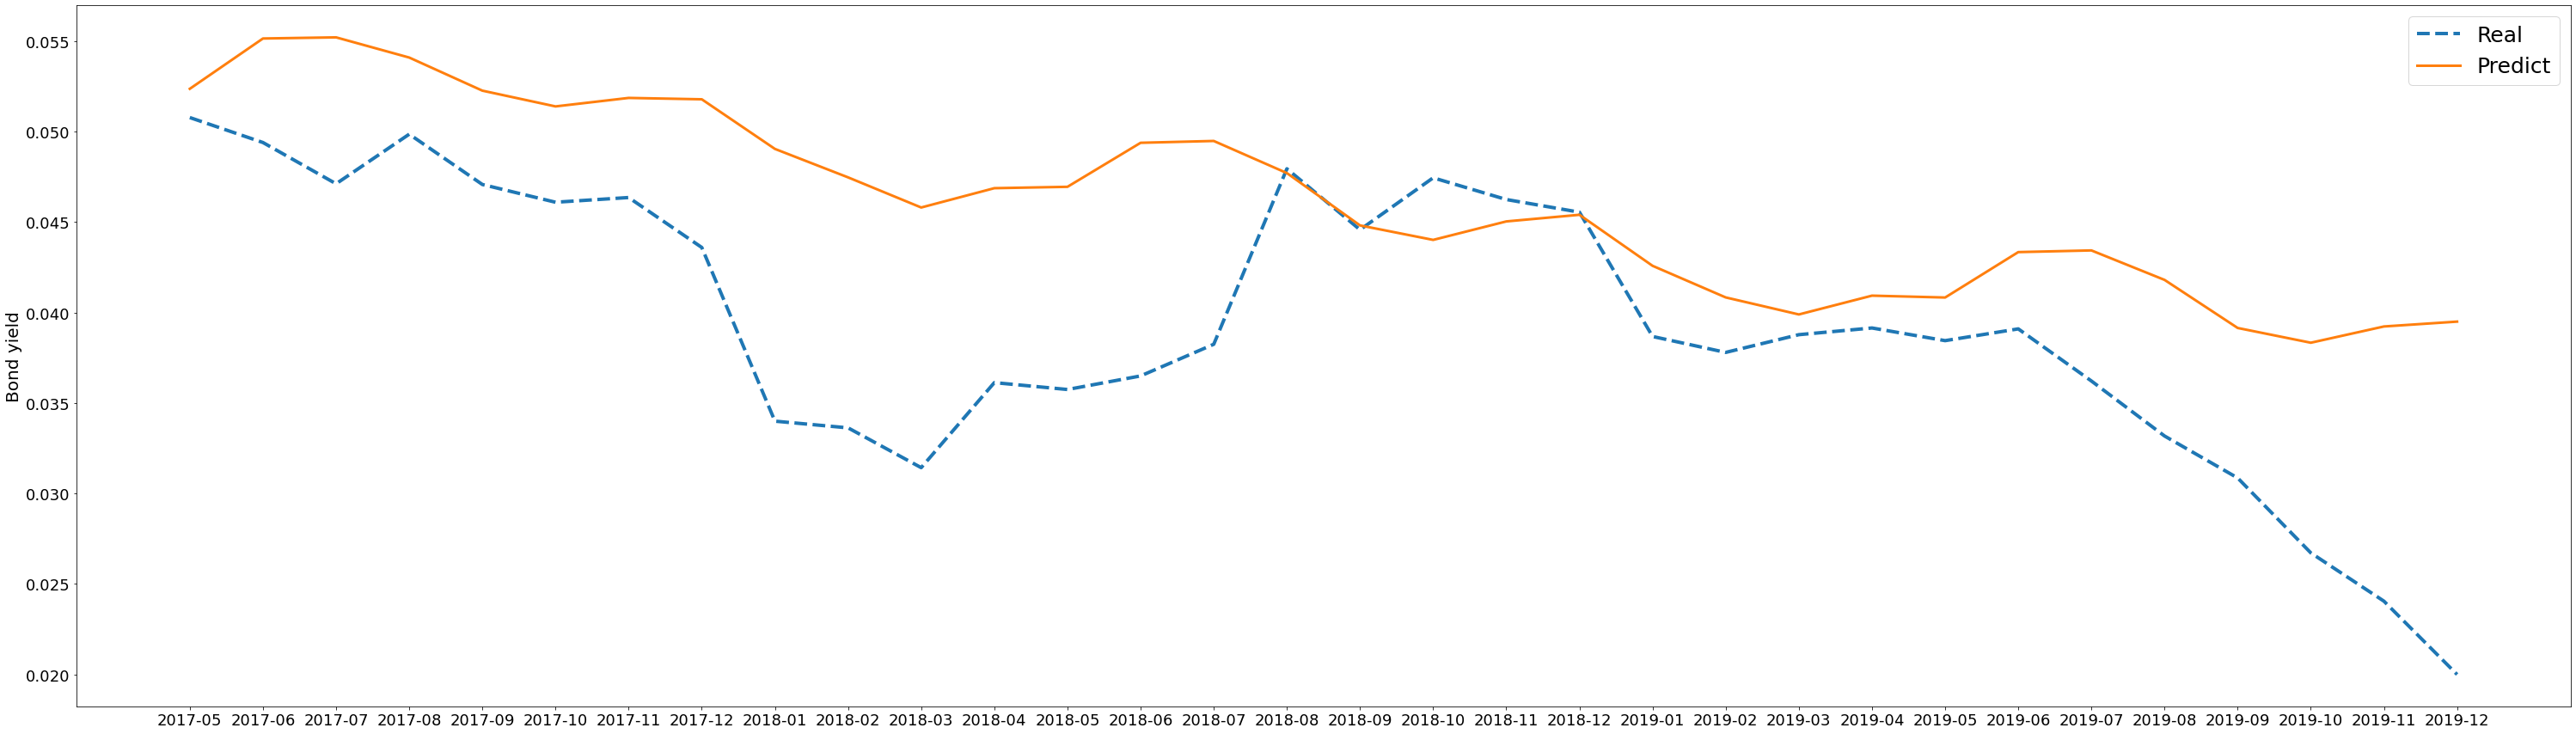

In [57]:
plt.figure(figsize=(52,15))

plt.plot(volatility.Real,'--',linewidth= 4)
plt.plot(volatility.Prediction,linewidth= 3)

plt.legend(['Real','Predict'],fontsize = 25.0)

plt.ylabel('Bond yield',fontsize = 20.0)

plt.xticks(fontsize = 18.0)
plt.yticks(fontsize = 18.0)
plt.show()

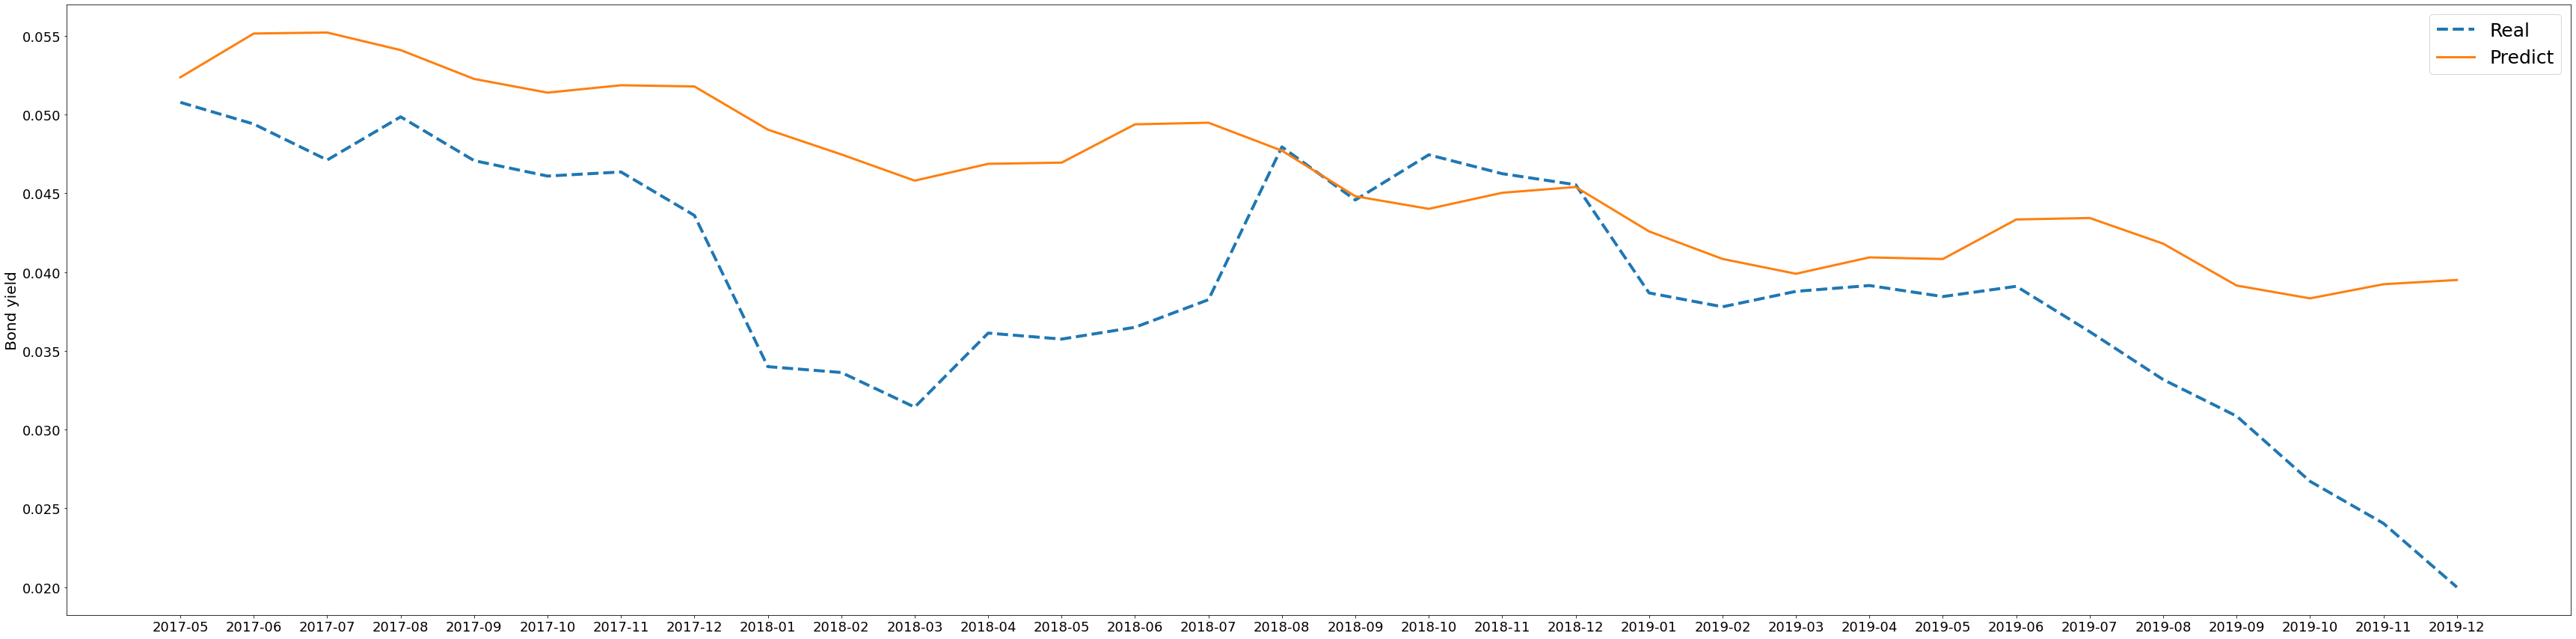

In [53]:
plt.figure(figsize=(60,15))

plt.plot(data_forecast,'--',linewidth= 4)
plt.plot(arima_forcast.Predict,linewidth= 3)

plt.legend(['Real','Predict'],fontsize = 25.0)

plt.ylabel('Bond yield',fontsize = 20.0)

plt.xticks(fontsize = 18.0)
plt.yticks(fontsize = 18.0)
plt.show()

***The volatility between actual and prediction price***

In [54]:
rmse = np.sqrt(mean_squared_error(volatility.Real, volatility.Prediction))
mae = mean_absolute_error(volatility.Real, volatility.Prediction)
mape = (mean_absolute_percentage_error(volatility.Real, volatility.Prediction))*100

In [55]:
print(f'RMSE = {round(rmse,6)}')
print(f'MAE  = {round(mae,6)}')
print(f'MAPE = {round(mape,2)}%')


RMSE = 0.008726
MAE  = 0.007042
MAPE = 21.29%
